This notebooks serves as a place to analyze the data as I progress in this [competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/).

In [1]:
import os, sys
from subprocess import Popen, PIPE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tifffile as tiff
import cv2
import random
import tqdm

In [22]:
# don't run this cell again, package already installed
!pip install libtiff

    100% |████████████████████████████████| 122kB 1.7MB/s ta 0:00:01
  Running setup.py bdist_wheel for libtiff ... done
  Stored in directory: /home/intern/.cache/pip/wheels/84/ed/d5/8acf7965cbd3020a0a1fec373ebc989567fa9c9d5791a8adbf
Successfully built libtiff


In [2]:
# for processing tiff files
import libtiff
# dir(libtiff)

In [3]:
# append the module dir path to the PythonPath
sys.path.append('../pyimgsaliency/')

import pyimgsaliency as psal

ImportError: No module named pyimgsaliency

In [5]:
proc = Popen('du -sh ../data/raw/*', shell=True, stdout=PIPE, stderr=PIPE)
print proc.communicate()[0]

690M	../data/raw/test-jpg
348M	../data/raw/test-jpg-additional
31G	../data/raw/test-tif-v2
687M	../data/raw/train-jpg
20G	../data/raw/train-tif-v2
1.4M	../data/raw/train_v2.csv



In [6]:
df_train = pd.read_csv('../data/raw/train_v2.csv')
print df_train.describe()
df_train.head(7)

         image_name           tags
count         40479          40479
unique        40479            449
top     train_29482  clear primary
freq              1          13636


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
5,train_5,haze primary water
6,train_6,agriculture clear cultivation primary water


In [7]:
image_files = df_train['image_name']
# pick out a random image
img_number = random.randint(0, 40478)

In [9]:
img = '../data/raw/train-tif-v2/' + image_files[img_number] + '.tif'
img_jpg = '../data/raw/train-jpg/' + image_files[img_number] + '.jpg'
print "Labels:", df_train.iloc[img_number]['tags']

im_tif = tiff.imread(img)
# im_tif = libtiff.TIFFfile(img)
im_jpg = im_tif[:,:,:3]
im_nir = im_tif[:,:,3]

print "original img:", im_tif.shape, type(im_tif)
# im_small = np.reshape(im_tif, [128, 128, 4])
# print im_small.shape

Labels: agriculture partly_cloudy primary road
original img: (256, 256, 4) <type 'numpy.ndarray'>


/home/intern/satellite/venv/local/lib/python2.7/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


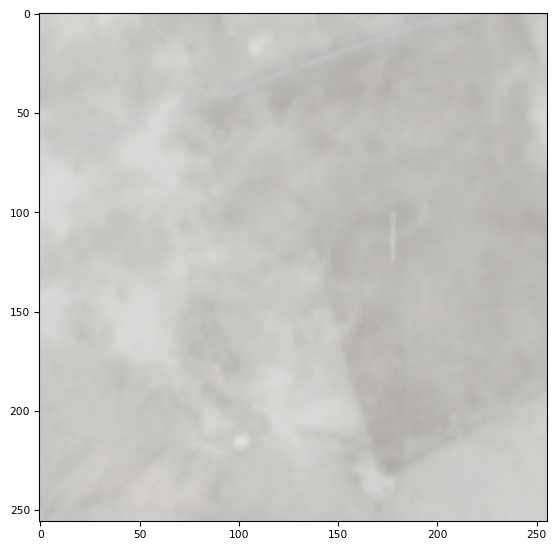

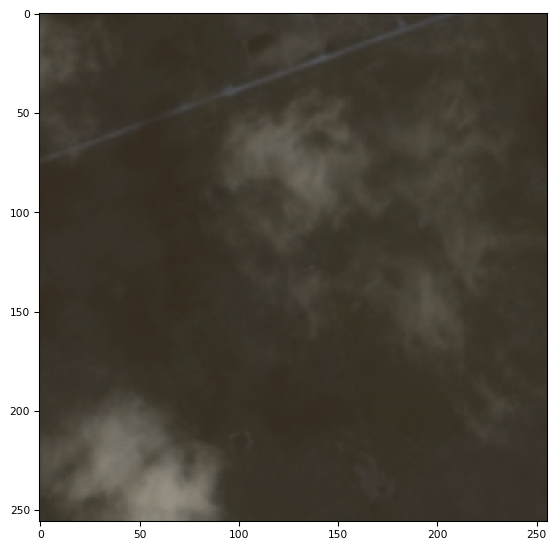

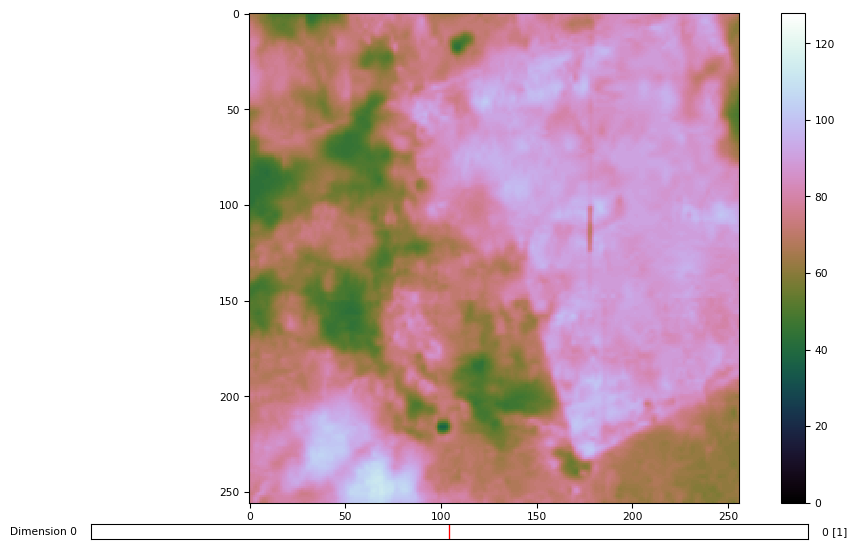

In [10]:
tiff.imshow(im_tif)
# plt.axis('off')
tiff.imshow(im_jpg)
# plt.axis('off')
tiff.imshow(im_nir)
# plt.axis('off')
plt.show()

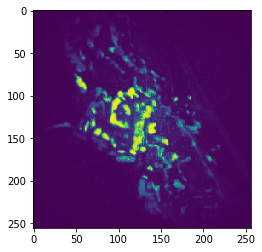

In [32]:
# mbd: maximum barrier detection, a method of generating saliency maps
mbd = psal.get_saliency_mbd(img0_jpg).astype('uint8')
# often, it is desirable to have a binary saliency map
binary_sal = psal.binarise_saliency_map(mbd,method='adaptive')

plt.imshow(mbd)
# plt.imshow(255 * binary_sal.astype('uint8'))
plt.show()

In [ ]:

rbd = psal.get_saliency_rbd(filename).astype('uint8')

img_jpg dims: (256, 256, 3)


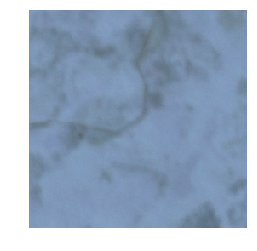

In [56]:
img_jpg = cv2.imread(img0_jpg)
print "img_jpg dims:", img_jpg.shape
plt.imshow(im_jpg)
plt.axis('off')
plt.show()

## Database Choices<a class="anchor" id="db-choices"></a>

Quite a few choices: LevelDB (Google), RocksDB, HyperlevelDB (both optimized variants of LevelDB), LMDB.

In Large Scale Machine Learning, when your database, say contains a 100M images, you need faster and more efficient  data throughput rates. That's where these databases come in handy.
    
>LMDB [Lightning Memory-Mapped Database] is a memory mapped copy of B+ tree while LevelDB is a Log structured Merge tree.

LevelDB (and its variants) is really disk-efficient (and write and read efficient too) because it uses data compaction to get rid of unused sections created during updates, unlike LMDB. LMDB just keeps on increasing the disk space required. But if you have a smaller database (not too small), anywhere around 2-5 GB, then LMDB is the way to go.

> This is actually what we’d expect for B-trees: they’re faster the fewer keys you have in them.  
Rocks (and basically any Level variant) won’t perform as well on spinning disks, but it’s not the primary target hardware for us.  
You could also potentially create a configuration with smaller shards and use LMDB for screaming fast performance.

The above has been taken from [here](https://www.influxdata.com/benchmarking-leveldb-vs-rocksdb-vs-hyperleveldb-vs-lmdb-performance-for-influxdb/).

There's also record.io used by the dmlc guys. Source: [here](http://mxnet.io/architecture/note_data_loading.html)

So for now, I will divide my data into multiple shards and use LMDB.

### Reshaping and Kernel size selection

#### Proposal - I: Preparing a saliency map to see the general variation in the pixel space

Depending on how the data is distributed in pixel space (which the saliency will give an idea of), we can possibly decide on how much the images should be rescaled and how big the filters should be accordingly.



## Network Architecture

This is pretty much what I saw in all in all the public kernels:
- Downscaling original images (256x256) to 32x32
- Working with .jpeg files, not the .tif files (which obviuosly contain much more data)
- Using a shallow network



## Network Initialization

Options:
1. Xavier Initialization
2. Initialization using Autoencoders